In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load data
# This assumes data is in a DataFrame called df with 'NDVI', 'NBR' as columns and 'label' as target column

data = pd.read_csv('../dataset_tables/final_dataset.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      251 non-null    object
 1   split   251 non-null    object
 2   Label   251 non-null    bool  
 3   NDVI    251 non-null    object
 4   NBR     251 non-null    object
 5   NDWI    251 non-null    object
 6   NDBI    251 non-null    object
 7   RGB     251 non-null    object
dtypes: bool(1), object(7)
memory usage: 14.1+ KB


In [ ]:
# Randomly drop 190 rows where label is 0
data = data.drop(data[data.Label == 0].sample(190, random_state=1).index)

In [3]:
def convert_string_to_list(item):
    if isinstance(item, (int, float)):
        return [item]
    s = str(item)
    s = s.replace('nan', '0')
    lst = ast.literal_eval(s)
    return lst

data['NDVI'] = data['NDVI'].apply(lambda x: convert_string_to_list(x))
data['NBR'] = data['NBR'].apply(lambda x: convert_string_to_list(x))
data['NDWI'] = data['NDWI'].apply(lambda x: convert_string_to_list(x))
data['NDBI'] = data['NDBI'].apply(lambda x: convert_string_to_list(x))


In [49]:
# Combine NBR and NDVI data into a single feature array
# Flatten each sublist and concatenate NBR and NDVI for each row
# X = np.array([np.ravel(ndvi + ndwi + nbr + ndbi)
#     for ndvi, ndwi, nbr, ndbi in zip(data['NDVI'], data['NDWI'], data['NBR'], data['NDBI'])])
# X = np.nan_to_num(X)

# Labels
# y = data['Label'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [68]:
# In datafram, if column split == "train" or "val" then it is training data
# Otherwise it is test data
train_data = data[(data['split'] == 'train') | (data['split'] == 'val')]
test_data = data[data['split'] == 'test']

X_train = np.array([np.ravel(ndvi + ndwi + ndbi)
    for ndvi, ndwi, ndbi in zip(train_data['NDVI'], train_data['NDWI'], train_data['NDBI'])])
X_train = np.nan_to_num(X_train)
y_train = train_data['Label'].values

X_test = np.array([np.ravel(ndvi + ndwi + ndbi)
    for ndvi, ndwi, ndbi in zip(test_data['NDVI'], test_data['NDWI'], test_data['NDBI'])])
X_test = np.nan_to_num(X_test)
y_test = test_data['Label'].values

In [63]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
for i in range(len(X)):
    print(X[i])

In [64]:
# Fine tune gamma and C range for RBF kernel
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train_resampled, y_train_resampled)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)


KeyboardInterrupt: 

In [69]:
# Classifier used: Radial Basis Function (RBF)
# it can combine multiple polynomial kernels multiple times of different degrees to
# project the non-linearly separable data into higher dimensional space

# gamma: https://www.ibm.com/docs/sr/spss-modeler/18.0.0?topic=node-svm-expert-options
# C: https://vitalflux.com/svm-rbf-kernel-parameters-code-sample/

model = svm.SVC(kernel='rbf', gamma=0.01, C=1.0).fit(X_train, y_train)


In [74]:
# Calculate model efficiency

y_pred = model.predict(X_test)


In [79]:
# Calculate the accuracy and f1 scores for SVM with RBF kernel

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8269
Precision: 1.0000
Recall: 0.1000
Mean Average Precision: 0.2731
F1-score: 0.1818

Classification Report:
              precision    recall  f1-score   support

       False       0.82      1.00      0.90        42
        True       1.00      0.10      0.18        10

    accuracy                           0.83        52
   macro avg       0.91      0.55      0.54        52
weighted avg       0.86      0.83      0.76        52


Confusion Matrix:
[[42  0]
 [ 9  1]]


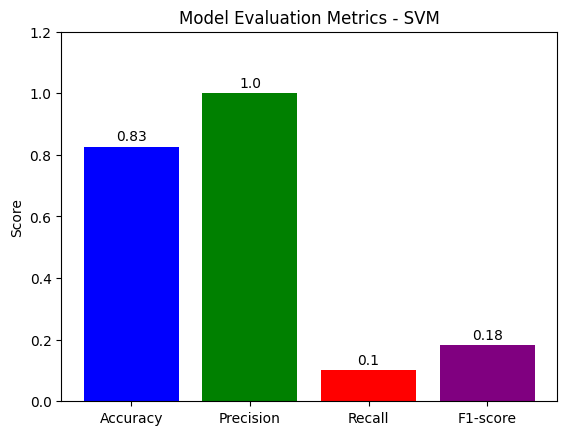

In [83]:
# Visualize the model evaluation metrics

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics - SVM')
plt.ylim(0, 1.2)  # to set y-axis limits from 0 to 1
plt.show()
